# Next Word Prediction - Irish Lyrics

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Install `tfutils`

In [5]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks
from tfutils.visualize import plot_learning_curve

## Check GPU

In [2]:
!nvidia-smi

Sat Jul 24 15:51:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2021-07-24 15:52:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2021-07-24 15:52:16 (114 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



## Load Data

In [5]:
!head -n 5 /tmp/irish-lyrics-eof.txt

Come all ye maidens young and fair
And you that are blooming in your prime
Always beware and keep your garden fair
Let no man steal away your thyme
For thyme it is a precious thing


In [10]:
with open('/tmp/irish-lyrics-eof.txt', 'r') as f:
    data = f.read()

In [11]:
data[:1000]

'Come all ye maidens young and fair\nAnd you that are blooming in your prime\nAlways beware and keep your garden fair\nLet no man steal away your thyme\nFor thyme it is a precious thing\nAnd thyme brings all things to my mind\nnlyme with all its flavours, along with all its joys\nThyme, brings all things to my mind\nOnce I and a bunch of thyme\ni thought it never would decay\nThen came a lusty sailor\nWho chanced to pass my way\nAnd stole my bunch of thyme away\nThe sailor gave to me a rose\nA rose that never would decay\nHe gave it to me to keep me reminded\nOf when he stole my thyme away\nSleep, my child, and peace attend thee\nAll through the night\nGuardian angels God will send thee\nSoft the drowsy hours are creeping\nHill and dale in slumber sleeping\nI my loving vigil keeping\nWhile the moon her watch is keeping\nWhile the weary world is sleeping\nOer thy spirit gently stealing\nVisions of delight revealing\nBreathes a pure and holy feeling\nThough I roam a minstrel lonely\nMy t

## Prepare corpus

In [13]:
corpus = data.lower().split('\n')
corpus[:5]

['come all ye maidens young and fair',
 'and you that are blooming in your prime',
 'always beware and keep your garden fair',
 'let no man steal away your thyme',
 'for thyme it is a precious thing']

## Tokenize 

* Create sequences of every possible n-grams 2, 3 .. for every tokenized sentence

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
w2id = tokenizer.word_index
id2w = {v:k for k, v in w2id.items()}

In [20]:
input_sequences = []

for line in corpus:
    seq = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(seq) + 1):
        ngram_seq = seq[:(i+1)]
        input_sequences.append(ngram_seq)

In [21]:
input_sequences[:5]

[[51, 12],
 [51, 12, 96],
 [51, 12, 96, 1217],
 [51, 12, 96, 1217, 48],
 [51, 12, 96, 1217, 48, 2]]

## Create $X$ and $y$

* Create pairs such that we predict the next token from preceding tokens
* Essentially, we are developing a language model, estimating the probability (distribution over all tokens in the vocab) of next token given the previous tokens. 

$P(X_{n}| X_{n-1}, X_{n-2}, X_{n-3} ... X_{1})$

In [22]:
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

16

In [23]:
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')
input_sequences[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   51,   12],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   51,   12,   96],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   51,   12,   96, 1217],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          51,   12,   96, 1217,   48],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   51,
          12,   96, 1217,   48,    2]], dtype=int32)

In [52]:
X, y = input_sequences[:, :-1], input_sequences[:, -1]

In [53]:
print(X.shape)

(13730, 15)


In [54]:
y.shape # Necessary for calculation of sparse_categorical_crossentropy

(13730,)

## Training and Test sets

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Word Embeddings

In [100]:
!wget https://nlp.stanford.edu/data/glove.6B.zip -P /tmp/
!unzip /tmp/glove.6B.zip -d /tmp/

Archive:  /tmp/glove.6B.zip
  inflating: /tmp/glove.6B.50d.txt   
  inflating: /tmp/glove.6B.100d.txt  
  inflating: /tmp/glove.6B.200d.txt  
  inflating: /tmp/glove.6B.300d.txt  


In [103]:
!head -n 5 /tmp/glove.6B.300d.txt

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

In [112]:
def load_txt_vec(fname, token2id=None):

    parse_all = token2id is None

    with open(fname, 'r') as f:
        first_line = f.readline()
        splt_line = first_line.split(' ')
        embed_dim = len(splt_line) - 1

        f.seek(0)

        if not parse_all:
            vocab_size = len(token2id) + 1
        else:
            token2id = {}
        
        embed_mat = np.zeros(shape=(vocab_size, embed_dim))

        if parse_all:
            for i, line in enumerate(f.readlines()):
                splt_line = line.split(' ')
                token = splt_line[0]
                vecs = np.array(splt_line[1:], dtype=np.float32)
                embed_mat[i] = vecs
                token2id[token] = i

        else:
            for line in f.readlines():
                splt_line = line.split(' ')
                token = splt_line[0]
                if token in token2id:
                    vecs = np.array(splt_line[1:], dtype=np.float32)
                    i = token2id[token]
                    embed_mat[i] = vecs
                
    return token2id, embed_mat

In [113]:
token2id, embed_mat = load_txt_vec('/tmp/glove.6B.300d.txt', w2id)

In [116]:
prop_no_embed = (embed_mat == 0).all(axis=1).mean()
print(f'{prop_no_embed:.2f}% not found')

0.05% not found


## Create a model

In [119]:
VOCAB_SIZE = len(w2id)
EMBEDDING_DIM = embed_mat.shape[1]

In [121]:
embed_mat.shape

(2690, 300)

In [122]:
VOCAB_SIZE

2689

In [124]:
model = tf.keras.models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM,
                     weights=[embed_mat], input_length=max_seq_len-1, trainable=False),
    layers.Bidirectional(layers.LSTM(units=128)),
    layers.Dropout(0.5),
    layers.Dense(VOCAB_SIZE, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 15, 300)           807000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2689)              691073    
Total params: 1,937,369
Trainable params: 1,130,369
Non-trainable params: 807,000
_________________________________________________________________


In [125]:
%%time

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=128)

Epoch 1/100
78/78 [==============================] - 3s 14ms/step - loss: 7.0003 - accuracy: 0.0554 - val_loss: 6.8111 - val_accuracy: 0.0482
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 6.4846 - accuracy: 0.0614 - val_loss: 6.7658 - val_accuracy: 0.0482
Epoch 3/100
78/78 [==============================] - 1s 6ms/step - loss: 6.3387 - accuracy: 0.0637 - val_loss: 6.7055 - val_accuracy: 0.0610
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 6.1438 - accuracy: 0.0734 - val_loss: 6.6271 - val_accuracy: 0.0719
Epoch 5/100
78/78 [==============================] - 1s 6ms/step - loss: 5.9346 - accuracy: 0.0838 - val_loss: 6.5478 - val_accuracy: 0.0801
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 5.7347 - accuracy: 0.0935 - val_loss: 6.4997 - val_accuracy: 0.0801
Epoch 7/100
78/78 [==============================] - 1s 6ms/step - loss: 5.5376 - accuracy: 0.1026 - val_loss: 6.4354 - val_accuracy: 0.0846
Epoch 8/100


### Learning Curve

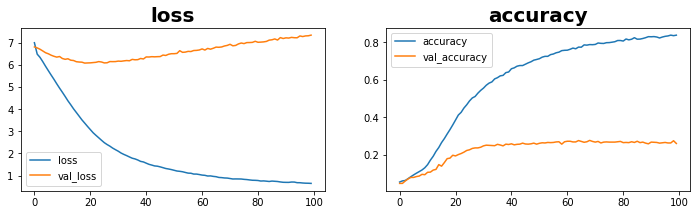

In [126]:
plot_learning_curve(history, extra_metric='accuracy');

## Predicting Next $N$ words

In [127]:
corpus[:100]

['come all ye maidens young and fair',
 'and you that are blooming in your prime',
 'always beware and keep your garden fair',
 'let no man steal away your thyme',
 'for thyme it is a precious thing',
 'and thyme brings all things to my mind',
 'nlyme with all its flavours, along with all its joys',
 'thyme, brings all things to my mind',
 'once i and a bunch of thyme',
 'i thought it never would decay',
 'then came a lusty sailor',
 'who chanced to pass my way',
 'and stole my bunch of thyme away',
 'the sailor gave to me a rose',
 'a rose that never would decay',
 'he gave it to me to keep me reminded',
 'of when he stole my thyme away',
 'sleep, my child, and peace attend thee',
 'all through the night',
 'guardian angels god will send thee',
 'soft the drowsy hours are creeping',
 'hill and dale in slumber sleeping',
 'i my loving vigil keeping',
 'while the moon her watch is keeping',
 'while the weary world is sleeping',
 'oer thy spirit gently stealing',
 'visions of delight rev

In [128]:
seed_text = 'I had a dream I stood beneath an orange sky'
cur_text_seq = pad_sequences(tokenizer.texts_to_sequences([seed_text]), maxlen=max_seq_len-1, padding='pre')
num_next_words = 10

for i in range(num_next_words):
    pred_prob = model.predict(cur_text_seq)[0]
    pred_token_id = pred_prob.argmax()
    cur_text_seq = np.hstack([cur_text_seq, np.array([[pred_token_id]])])


final_seq = tokenizer.sequences_to_texts(cur_text_seq)[0]
print(final_seq)

i had a dream i stood beneath an sky of night unseen by night side my side side by
